In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

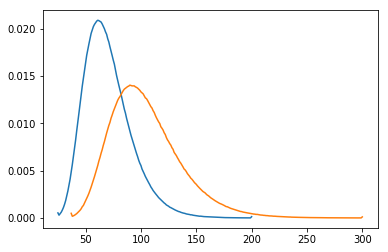

The average of w dist is 69764. The average of z dist is 104072


In [2]:
# calibration: unit for money is thousand per year, 2018 Chinese data is collected, suppose wage dist is log normal and independent
interest_rate=0.0435  #the 1-year interest rate in 2018 is 4.35%
beta=1/(1+interest_rate)
c=int(10.731)  # rural disposable income is 10731 in 2018,assuming total income is 10731

# simulate wage dist for old industry
urban_disposable_income_w=int(67.990)  #in 2018, in BJ, urban disposable income is 67990
w_min,w_max=int(25.440),200  #in 2018, minimun wage in BJ was 2120 per month so w_min is 254.4 (21.2*12) but minimun wage is not disposable income
w_num=w_max-w_min+1  
w_vec=np.linspace(w_min,w_max,w_num)

#obtain the empirical log normal distribution
dist_mean_w,dist_num=np.round(np.log(urban_disposable_income_w),1),10000000
dist_std_w=np.round((dist_mean_w-np.log(w_min))/3,1) # suppose the lower bound is w_min, based on 3 sigma rule, need further investigation
dist_w=np.random.lognormal(dist_mean_w,dist_std_w,dist_num)

#obtain the pdf of old industry
w_pdf=np.zeros(w_num)
w_pdf[0]=np.sum(w_vec[0]>=dist_w)  #lognormal 是正无穷的，然而wage有下限，因此把下限的pdf设为小于下限的概率之和
for ii in range(1,w_num-1):
    w_pdf[ii]=np.sum(np.logical_and(w_vec[ii-1]<dist_w,dist_w<=w_vec[ii]))
w_pdf[-1]=np.sum(w_vec[-2]<dist_w)  #lognormal 是正无穷的，然而wage有上限，因此把上限的pdf设为 大于上限的概率之和
w_pdf=w_pdf/dist_num

#print('the sum of pdf is %.2f'%np.sum(w_pdf))  #to check whether pdf sum up to one

# simulate wage dist for new industry
factor=1.5
urban_disposable_income_z=int(urban_disposable_income_w*factor)
z_min,z_max=int(w_min*factor),300
z_num=z_max-z_min+1  
z_vec=np.linspace(z_min,z_max,z_num)

#obtain the empirical log normal distribution
dist_mean_z,dist_num=np.round(np.log(urban_disposable_income_z),1),10000000
dist_std_z=np.round((dist_mean_z-np.log(z_min))/3,1) # suppose the lower bound is z_min, based on 3 sigma rule, need further investigation
dist_z=np.random.lognormal(dist_mean_z,dist_std_z,dist_num)

#obtain the pdf of new industry
z_pdf=np.zeros(z_num)
z_pdf[0]=np.sum(z_vec[0]>=dist_z)  #lognormal 是正无穷的，然而wage有下限，因此把下限的pdf设为小于下限的概率之和
for ii in range(1,z_num-1):
    z_pdf[ii]=np.sum(np.logical_and(z_vec[ii-1]<dist_z,dist_z<=z_vec[ii]))
z_pdf[-1]=np.sum(z_vec[-2]<dist_z)  #lognormal 是正无穷的，然而wage有上限，因此把上限的pdf设为 大于上限的概率之和
z_pdf=z_pdf/dist_num

#print('the sum of pdf is %.2f'%np.sum(z_pdf))  #to check whether pdf sum up to one

# check the dist
plt.plot(w_vec,w_pdf)
plt.plot(z_vec,z_pdf)
plt.show()

print('The average of w dist is %d. The average of z dist is %d'%(np.mean(dist_w)*1000,np.mean(dist_z)*1000))
joint_pdf=((z_pdf.reshape(len(z_pdf),1)*100)@(w_pdf.reshape(1,len(w_pdf))*100))/10000  #multiply by 100 for computational sake 

In [3]:
def job_search(T=4,fee=30,subsidy=10,tax=7,tol=1):
    tuition=(fee+urban_disposable_income_w)*T*(1-beta)
    time_start=time.time()
    ctr=0

    v_new=np.zeros((joint_pdf.shape[0],joint_pdf.shape[1]))
    v_old=np.ones((joint_pdf.shape[0],joint_pdf.shape[1]))*1000

    while np.max(np.abs(v_new-v_old))>tol:   
        if ctr%50==0:
            print('%d th time for job search update begins, the diff is %.2f'%(ctr,np.max(np.abs(v_new-v_old))))

        v_old=np.copy(v_new)
        v_expected=(v_old*joint_pdf).sum()  # unconditional expectation

        for ii in range(joint_pdf.shape[0]):  #ii is the index for z  
            for jj in range(joint_pdf.shape[1]):  #jj is the index for w
                v_new[ii,jj]=max(z_vec[ii]+beta*((v_old[ii,:]*w_pdf).sum())-tuition+subsidy,
                                 w_vec[jj]+beta*((v_old[:,jj]*z_pdf).sum())-tax,c+beta*v_expected-tax)
        ctr+=1

    time_end=time.time()
    time_during=time_end-time_start

    print('The running time for job search is %.2f seconds'%time_during)

    decision=np.zeros((joint_pdf.shape[0],joint_pdf.shape[1]))
    for ii in range(joint_pdf.shape[0]):  #ii is the index for z
        for jj in range(joint_pdf.shape[1]):  #jj is the index for w
            decision[ii,jj]=np.argmax([(z_vec[ii]+beta*((v_old[ii,:]*w_pdf).sum()))-tuition+subsidy,
                                       w_vec[jj]+beta*((v_old[:,jj]*z_pdf).sum())-tax,c+beta*v_expected-tax])

    decision=pd.DataFrame(decision)
    decision.columns=w_vec.astype(int)
    decision.index=z_vec.astype(int)

    value=pd.DataFrame(v_new)
    value.columns=w_vec.astype(int)
    value.index=z_vec.astype(int)

    # compute the prob of each state
    out_index=decision==2
    out_prob=joint_pdf[out_index].sum()
    print('The probability of staying out is %.2f '%(out_prob*100)+'%')

    old_ind_index=decision==1
    old_ind_prob=joint_pdf[old_ind_index].sum()
    print('The probability of old industry is %.2f '%(old_ind_prob*100)+'%')

    new_ind_index=decision==0
    new_ind_prob=joint_pdf[new_ind_index].sum()
    print('The probability of new industry is %.2f '%(new_ind_prob*100)+'%')
    
    fiscal_balance=(1-new_ind_prob)*100*tax-new_ind_prob*100*subsidy  #the fiscal balance is inflated for computational sake
    print('The fiscal balance is %.4f'%fiscal_balance)
    
    return fiscal_balance,new_ind_prob*100,old_ind_prob*100,out_prob*100,decision,value,tuition

In [10]:
# check the job search function
fiscal_balance,new_ind_share,old_ind_share,out_share,decision,value, tuition=job_search(T=4,fee=30,subsidy=3,tax=1.88,tol=1)

0 th time for job search update begins, the diff is 1000.00
50 th time for job search update begins, the diff is 35.60
100 th time for job search update begins, the diff is 4.24
The running time for job search is 68.65 seconds
The probability of staying out is 6.33 %
The probability of old industry is 53.76 %
The probability of new industry is 39.91 %
The fiscal balance is -6.7590


In [6]:
def bisection_for_tax(left=0,right=7,subsidy=5,tolerance=10): # Left and right are tax.fiscal balance must be - if left=0, it is + if right=10. so bisection is feasible
    #tolerance for fiscal balance has already been inflated by 100
    time_start=time.time()
    ctr=1
    middle=(left+right)/2
    print('%d th round for bisection(tax) starts, ensuing tax is %.2f'%(ctr,middle))
    fiscal_balance,new_ind_share,old_ind_share,out_share,decision,value, tuition=job_search(subsidy=subsidy,tax=middle)
    print('%d th round for bisection(tax) finished. The fiscal balance is %.2f. New ind share is %.2f'%(ctr,fiscal_balance,new_ind_share))
    print('\n')
    
    while np.abs(fiscal_balance)>tolerance:
        ctr+=1
        print('%d th round for bisection(tax) starts'%ctr)
        if fiscal_balance>0:
            right=middle
        else:
            left=middle
        middle=(left+right)/2
        fiscal_balance,new_ind_share,old_ind_share,out_share,decision,value, tuition=job_search(subsidy=subsidy,tax=middle)
        print('%d th round for bisection(tax) finished. The fiscal balance is %.2f. New ind share is %.2f'%(ctr,fiscal_balance,new_ind_share))
        print('\n')
        
        if ctr>10:
            print('The num of rounds for bisection(tax) exceeds 10 times. Break!')
            break
    
    time_end=time.time()
    time_during=time_end-time_start
    print('The running time for bisection(tax) is %.2f seconds'%time_during)
    
    return middle,fiscal_balance,new_ind_share,old_ind_share,out_share,decision,value,tuition  # middle here is ensuing tax

In [9]:
# check for the bisection_for_tax
middle,fiscal_balance,new_ind_share,old_ind_share,out_share,decision,value,tuition=bisection_for_tax(subsidy=3)
print('The ensuing tax is %.2f. The fiscal balance is %.2f. New ind share is %.2f. old ind share is %.2f. out share is %.2f'
      %(middle,fiscal_balance,new_ind_share,old_ind_share,out_share))

1 th round for bisection(tax) starts
0 th time for job search update begins, the diff is 1000.00
50 th time for job search update begins, the diff is 35.60
100 th time for job search update begins, the diff is 4.24
The running time for job search is 70.62 seconds
The probability of staying out is 6.33 %
The probability of old industry is 53.69 %
The probability of new industry is 39.97 %
The fiscal balance is 30.1381
1 th round for bisection(tax) finished. The fiscal balance is 30.14. New ind share is 39.97


2 th round for bisection(tax) starts
0 th time for job search update begins, the diff is 1000.00
50 th time for job search update begins, the diff is 35.60
100 th time for job search update begins, the diff is 4.24
The running time for job search is 69.06 seconds
The probability of staying out is 6.33 %
The probability of old industry is 53.80 %
The probability of new industry is 39.86 %
The fiscal balance is -44.4108
2 th round for bisection(tax) finished. The fiscal balance is -

In [7]:
def bisection_for_share(target_share,left=0,right=10,tolerance=0.05): #target_share should be rate*100,left and right are subsidy
    time_start=time.time()
    ctr=1
    middle=(left+right)/2  #middle here is subsidy
    print('%d th round for bisection(target share) starts,subsidy is %.2f'%(ctr,middle))
    tax,fiscal_balance,new_ind_share,old_ind_share,out_share,decision,value,tuition=bisection_for_tax(subsidy=middle)
    print('%d th round for bisection(target share) finished.The subsidy is %.2f.The tax is %.2f. New ind share is %.2f.The fiscal balance is %.2f.'%(ctr,middle,tax,new_ind_share,fiscal_balance))
    print('\n')
    
    while np.abs(new_ind_share-target_share)>tolerance: # notice that the shares have been inflated by 100 in job_search function
        ctr+=1
        print('%d th round for bisection(target share) starts'%ctr)
        if (new_ind_share-target_share)>0:
            right=middle
        else:
            left=middle
        middle=(left+right)/2
        print('subsidy is %.2f'%middle)
        tax,fiscal_balance,new_ind_share,old_ind_share,out_share,decision,value,tuition=bisection_for_tax(subsidy=middle)
        print('%d th round for bisection(target share) finished.The subsidy is %.2f.The tax is %.2f. New ind share is %.2f.The fiscal balance is %.2f.'%(ctr,middle,tax,new_ind_share,fiscal_balance))
        print('\n')
        
        if ctr>10:
            print('The num of rounds for bisection(target share) exceeds 10 times. Break!')
            break
    
    time_end=time.time()
    time_during=time_end-time_start
    print('The running time for bisection(target share) is %.2f seconds'%time_during)
    
    return middle,tax,new_ind_share,old_ind_share,out_share,fiscal_balance,decision,value,tuition

In [8]:
subsidy,tax,new_ind_share,old_ind_share,out_share,fiscal_balance,decision,value,tuition=bisection_for_share(target_share=41)
print('The subsidy is %.2f.The tax is %.2f. New ind share is %.2f.The fiscal balance is %.2f.'%(subsidy,tax,new_ind_share,fiscal_balance))

1 th round for bisection(target share) starts,subsidy is 5.00
1 th round for bisection(tax) starts, ensuing tax is 3.50
0 th time for job search update begins, the diff is 1000.00
50 th time for job search update begins, the diff is 35.85
100 th time for job search update begins, the diff is 4.26
The running time for job search is 61.70 seconds
The probability of staying out is 5.53 %
The probability of old industry is 53.94 %
The probability of new industry is 40.53 %
The fiscal balance is 5.4614
1 th round for bisection(tax) finished. The fiscal balance is 5.46. New ind share is 40.53


The running time for bisection(tax) is 62.60 seconds
1 th round for bisection(target share) finished.The subsidy is 5.00.The tax is 3.50. New ind share is 40.53.The fiscal balance is 5.46.


2 th round for bisection(target share) starts
subsidy is 7.50
1 th round for bisection(tax) starts, ensuing tax is 3.50
0 th time for job search update begins, the diff is 1000.00
50 th time for job search update 

In [9]:
# double check the result of bisection_for_share
fiscal_balance,new_ind_share,old_ind_share,out_share,decision,value, tuition=job_search(T=4,fee=30,subsidy=6.25,tax=4.38,tol=1)
print('The fiscal balance is %.2f. New ind share is %.2f. old ind share is %.2f. out share is %.2f'
      %(fiscal_balance,new_ind_share,old_ind_share,out_share))

0 th time for job search update begins, the diff is 1000.00
50 th time for job search update begins, the diff is 36.01
100 th time for job search update begins, the diff is 4.28
The running time for job search is 72.26 seconds
The probability of staying out is 5.29 %
The probability of old industry is 53.74 %
The probability of new industry is 40.96 %
The fiscal balance is 2.5500
The fiscal balance is 2.55. New ind share is 40.96. old ind share is 53.74. out share is 5.29


In [4]:
# convert decision to income
income=np.zeros((decision.shape))
decision_value=np.copy(decision)
for ii in range(income.shape[0]):
    for jj in range(income.shape[1]):
        if decision_value[ii,jj]==2:
            income[ii,jj]=c
        elif decision_value[ii,jj]==1:
            income[ii,jj]=decision.columns[jj]
        else:
            income[ii,jj]=decision.index[ii]

In [5]:
# compute the expected income
expected_income=(income*joint_pdf).sum()*1000
print('The expected income is %.2f'%expected_income)

The expected income is 97190.85


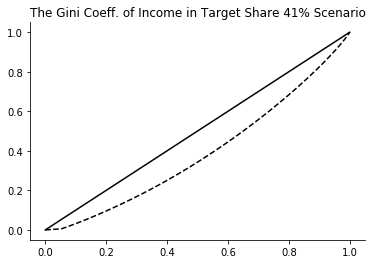

The Gini coefficient for income is 0.22689


In [6]:
# compute the Gini Coeff. for income
# step 1: compute the income and weight(sum up to 1)
income_range=pd.Series(income.reshape(1,income.shape[0]*income.shape[1])[0]).unique()
weight=np.array([joint_pdf[income==ii].sum() for ii in income_range])
income_range=np.append([0],income_range)
weight=np.append([0],weight)
# step 2: sort by income, ascending
# step 3: compute the accumulative weight sum 
weight_cumsum=weight.cumsum()
# step 4: compute the accumulative income sum 
income_sum_array=income_range*weight
income_cumsum=income_sum_array.cumsum()
income_cumsum=income_cumsum/sum(income_sum_array)
# step 5: calculate the Gini coefficients
weight_diff=weight_cumsum[1:]-weight_cumsum[0:-1]
gini_diff=weight_cumsum-income_cumsum
Gini_income=sum(gini_diff[1:]*weight_diff)  # gini_coeff will be overestimated if gini_diff[1:]

fig, ax = plt.subplots(1, 1,figsize=(6, 4))
ax.plot(weight_cumsum,weight_cumsum,'k-')
ax.plot(weight_cumsum,income_cumsum,'k--')
ax.set_title('The Gini Coeff. of Income in Target Share 41% Scenario')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()
fig.savefig('The Gini Coeff. of Income in target share 41% Scenario.pdf')

print('The Gini coefficient for income is %.5f'%(2*Gini_income))

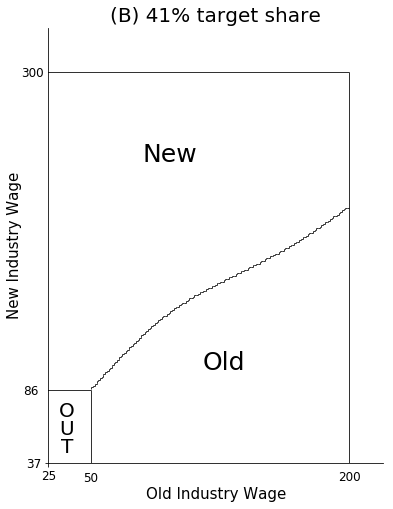

In [8]:
# draw the decision graph
#https://blog.csdn.net/weixin_41743584/article/details/99855902

fig1 = plt.figure(figsize=(6, 8))
ax = plt.axes()

plt.xlim(25,220)
plt.ylim(37,330)

#draw the range
plt.hlines(300, 0, 200, colors='k', linestyle="-",linewidth=0.8)
plt.vlines(200, 0, 300, colors='k', linestyle="-",linewidth=0.8)

# draw the reservation area
reservation_width=24+sum(decision.iloc[0,:]>1)
reservation_length=36+sum(decision.iloc[:,0]>0)
plt.hlines(reservation_length, 0,reservation_width, colors='k', linestyle="-",linewidth=0.8)
plt.vlines(reservation_width, 0, reservation_length, colors='k', linestyle="-",linewidth=0.8)

#draw the old-new boundary
for ii in range(decision.shape[0]):
    for jj in range(decision.shape[1]-1):
        if decision.iloc[ii,jj]==0 and decision.iloc[ii,jj+1]==1:
            plt.vlines(jj+25, ii+37,ii+38, colors='k', linestyle="-",linewidth=0.8)

for jj in range(decision.shape[1]):
    for ii in range(decision.shape[0]-1):
        if decision.iloc[ii,jj]==1 and decision.iloc[ii+1,jj]==0:
            plt.hlines(ii+38, jj+24,jj+25, colors='k', linestyle="-",linewidth=0.8)

#label the number and decision
plt.text(10, reservation_length-3, str(reservation_length),fontsize=12)
plt.text(9, 297, "300",fontsize=12)
plt.text(reservation_width-5, 24, str(reservation_width),fontsize=12)
plt.text(194, 25, "200",fontsize=12)
plt.text(31,68,'O',fontsize=20)
plt.text(31.5,56,'U',fontsize=20)
plt.text(32.5,44,'T',fontsize=20)
plt.text(115,100,'Old',fontsize=25)
plt.text(80,240,'New',fontsize=25)


#set axis notation
plt.xticks(np.linspace(25,250,1),fontsize=12)
plt.yticks(np.linspace(37,350,1),fontsize=12)

plt.xlabel('Old Industry Wage',fontsize=15)
plt.ylabel('New Industry Wage',fontsize=15)
plt.title('(B) 41% target share',fontsize=20)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()
fig1.savefig('Labor Participation Choice in target share 41% Scenario.pdf')

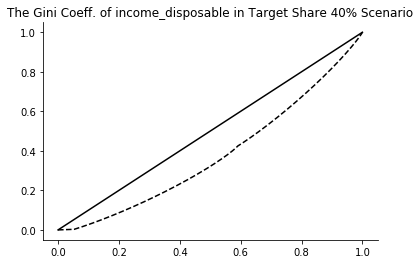

The Gini coefficient for income_disposable is 0.24937


In [16]:
# compute the gini coeff. for disposable income
# convert decision to disposable income
income_disposable=np.zeros((decision.shape))
decision_value=np.copy(decision)
for ii in range(income_disposable.shape[0]):
    for jj in range(income_disposable.shape[1]):
        if decision_value[ii,jj]==2:
            income_disposable[ii,jj]=c-4.38
        elif decision_value[ii,jj]==1:
            income_disposable[ii,jj]=decision.columns[jj]-4.38
        else:
            income_disposable[ii,jj]=decision.index[ii]+6.25
            
# compute the Gini Coeff. for income_disposable
# step 1: compute the income_disposable and weight(sum up to 1)
income_disposable_range=pd.Series(income_disposable.reshape(1,income_disposable.shape[0]*income_disposable.shape[1])[0]).unique()
weight=np.array([joint_pdf[income_disposable==ii].sum() for ii in income_disposable_range])
income_disposable_range=np.append([0],income_disposable_range)
weight=np.append([0],weight)
# step 2: sort by income_disposable, ascending
# step 3: compute the accumulative weight sum 
weight_cumsum=weight.cumsum()
# step 4: compute the accumulative income_disposable sum 
income_disposable_sum_array=income_disposable_range*weight
income_disposable_cumsum=income_disposable_sum_array.cumsum()
income_disposable_cumsum=income_disposable_cumsum/sum(income_disposable_sum_array)
# step 5: calculate the Gini coefficients
weight_diff=weight_cumsum[1:]-weight_cumsum[0:-1]
gini_diff=weight_cumsum-income_disposable_cumsum
Gini_income_disposable=sum(gini_diff[1:]*weight_diff)  # gini_coeff will be overestimated if gini_diff[1:]

fig, ax = plt.subplots(1, 1,figsize=(6, 4))
ax.plot(weight_cumsum,weight_cumsum,'k-')
ax.plot(weight_cumsum,income_disposable_cumsum,'k--')
ax.set_title('The Gini Coeff. of income_disposable in Target Share 40% Scenario')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()
#fig.savefig('The Gini Coeff. of income_disposable in target share 7% Scenario.pdf')

print('The Gini coefficient for income_disposable is %.5f'%(2*Gini_income_disposable))